In [1]:
import models
import torchvision.transforms as transforms

%env CUDA_VISIBLE_DEVICES 0

cnn_path = '../../../nn/models/cnn.t7'
lstm_path = '../../../nn/models/lstm.t7'
resolution = 112

model = models.FullModel(cnn_path, lstm_path, return_label=True)

rgb_transform= transforms.Compose([
    transforms.Resize((resolution, resolution)),
    transforms.ToTensor(),
    transforms.Normalize(
        (0.04275529876472071,),
        (0.12779259683327668,)),
])

dep_transform = transforms.Compose([
    transforms.Resize((resolution, resolution)),
    transforms.ToTensor(),
    transforms.Normalize(
        (0.15016975864264548,),
        (0.15443158397547746,)),
])

env: CUDA_VISIBLE_DEVICES=0


/usr/local/lib/python3.5/dist-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.5/dist-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv3d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.5/dist-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm3d' has changed. you can retrieve the original source code by accessing the object's source attribute o

==> Loading CNN from epoch 888, acc=100.000
==> Loading LSTM from epoch 861, acc=83.684


Connecting to hello world server...


<IPython.core.display.Javascript object>


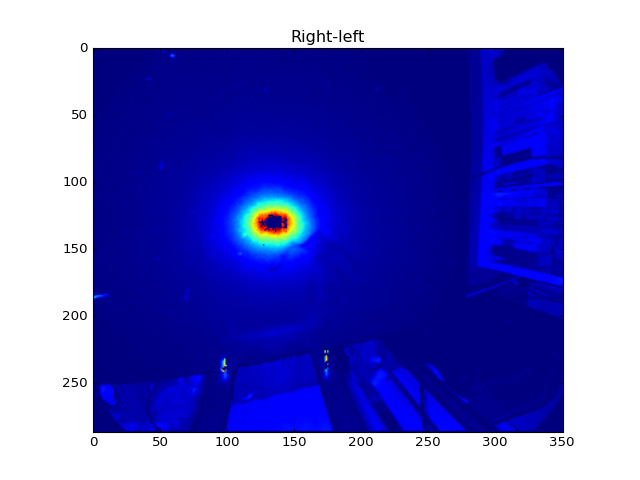

In [2]:
%matplotlib notebook

import zmq
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
import cam

from IPython import display

context = zmq.Context()

# Socket to talk to server
print("Connecting to hello world server...")
socket = context.socket(zmq.REQ)
socket.connect("tcp://localhost:5555")

tsr_list = [torch.zeros((1, 2, 112, 112)) for _ in range(16)]
#plt.figure(figsize=(3,3))
fig,ax = plt.subplots(1,1)
# Do 10 requests, waiting each time for a response
for i, request in enumerate(range(1000)):
    socket.send_string("Hello")

    # Get the reply.
    message = socket.recv()
    #print("Received reply ", request, "[", message, "]")
    path = message.decode("utf-8")
    # Load frame
    frame = np.load(path)
    orig_arr = frame[0, :, :]
    
    # Get grayscale part
    rgb_arr = frame[0, :, :215].T
    dep_arr = frame[1, :, :215].T
    
    rgb_arr = rgb_arr - rgb_arr.min()
    rgb_arr = rgb_arr / rgb_arr.max()
    rgb_arr = rgb_arr * 255.0
    rgb_arr = rgb_arr.astype(np.uint8)
    
    dep_arr = dep_arr - dep_arr.min()
    dep_arr = dep_arr / dep_arr.max()
    dep_arr = dep_arr * 255.0
    dep_arr = dep_arr.astype(np.uint8)
    
    #print(rgb_arr.shape, dep_arr.shape)
    rgb_img = Image.fromarray(rgb_arr)
    dep_img = Image.fromarray(dep_arr)

    ###
    rgb_tsr = rgb_transform(rgb_img).unsqueeze(0)
    dep_tsr = dep_transform(dep_img).unsqueeze(0)
    tsr = torch.cat([rgb_tsr, dep_tsr], dim=1)
    tsr_list.append(tsr)
    tsr_list = tsr_list[1:]
    vid = torch.cat(tsr_list)

    pred = model(vid)
    #print(pred)
    ###
    # Clear figure (necessary to avoid buildup and lag)
    plt.clf()
    # Draw image
    plt.imshow(orig_arr)#, cmap='gray')
    plt.title(pred)
    # Show image to user
    fig.canvas.draw()
